# Fu, Zhuo, et al. "High fidelity entanglement of neutral atoms via a Rydberg-mediated single-modulated-pulse controlled-PHASE gate." arXiv preprint arXiv:2109.02491 (2021).

In [80]:
from qutip import *
import math

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from pulseShape import Saffman_shape
from fidelity import fidelity
from optimize.de import de
from quantumDy import quantumDy

# Physical system

In [147]:
### Hamiltonian ###
def Hamiltonian(shape_omegas):
    # 0, 1, p, r
    qd = quantumDy(4)

    delta = 2*np.pi * -3.512
    B = 2*np.pi * 500           # (MHz) Strength of Rydberg states interaction
    deltap = 2*np.pi * (-3)     # (MHz)

    # H01 & H10
    H01_omegas = 2*np.pi * 1/2 * tensor( ( qd.transition(0,3) + qd.transition(3,0) ), qd.transition(1,1) )
    H01_delta = delta * tensor( qd.transition(3,3), qd.transition(1,1) )
    H10_omegas = 2*np.pi * 1/2 * tensor( qd.transition(1,1), ( qd.transition(0,3) + qd.transition(3,0) ) )
    H10_delta = delta * tensor( qd.transition(1,1), qd.transition(3,3) )
    
    H01 = [ [H01_omegas, shape_omegas], [H01_delta, '1'] ]
    H10 = [ [H10_omegas, shape_omegas], [H10_delta, '1'] ]
    
    # H00
    HI_omegas = 2*np.pi * 1/2 * ( tensor(qd.transition(0,3), qd.transition(0,0)) + tensor(qd.transition(0,0), qd.transition(0,3)) 
                      + tensor(qd.transition(3,0), qd.transition(0,0)) + tensor(qd.transition(0,0), qd.transition(3,0))
                      + tensor(qd.transition(3,3), qd.transition(3,0)) + tensor(qd.transition(3,3), qd.transition(0,3))
                      + tensor(qd.transition(3,0), qd.transition(3,3)) + tensor(qd.transition(0,3), qd.transition(3,3)) )
    HI_delta = 1/2 * delta * ( tensor(qd.transition(3,3), qd.transition(0,0)) + tensor(qd.transition(0,3), qd.transition(3,0)) 
                     + tensor(qd.transition(3,0), qd.transition(0,3)) + tensor(qd.transition(0,0), qd.transition(3,3)) 
                     + 4*tensor(qd.transition(3,3), qd.transition(3,3)) )
    HF = ( B * ( tensor(qd.transition(3,2), qd.transition(3,2)) + tensor(qd.transition(2,3), qd.transition(2,3)) ) 
         + deltap * ( tensor(qd.transition(2,2), qd.transition(2,2)) ) )
    
    H00 = [ [HI_omegas, shape_omegas], [HI_delta, '1'], [HF, '1'] ]
    
    H = H01 + H10 + H00

    return H


### Pulse shape omegas(t) and delta(t) ###
def PulseShape(T_gate):
    
    Tg = T_gate    #(/mu s)
    beta = [1.419, 0, 5.076, 13.425]
    coe = [8, 28, 56, 70]
    
    def shape_omegas(t, arg):
        nu = 8
        n = 4
        shape = 0
        tg = t/Tg
        for i in range(n):
            shape += beta[i] * coe[i] * (  (tg**(i+1)) * ( (1-tg)**(nu-(i+1))) + (tg**(nu-(i+1)) * (1-tg)**(i+1))  )
        return shape
    
    return shape_omegas

### Initial state, rhoi() ###
def init_state(rhoc, rhot):
    return tensor(basis(4,rhoc), basis(4,rhot))

In [148]:
# Gate operation
def GateOp(rho_init, targets):
    times = np.linspace(0.0, 1, 100)
    T_gate = 1              # (mu s) Total gate time
 
    shape_omegas = PulseShape(T_gate)
    H = Hamiltonian(shape_omegas)
    
    results = mesolve(H, rho_init, times, [], targets, options=Options(nsteps=10000))
    return results

In [164]:
a = GateOp(init_state(0,0), [init_state(0,0), 1/np.sqrt(2) * (init_state(0,3)+init_state(3,0))])
times = np.linspace(0.0, 1, 100)

b = GateOp(init_state(0,1), [init_state(0,1), init_state(3,1)] )

/home/thc/miniconda3/envs/rdqc/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/thc/miniconda3/envs/rdqc/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/thc/miniconda3/envs/rdqc/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/thc/miniconda3/envs/rdqc/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


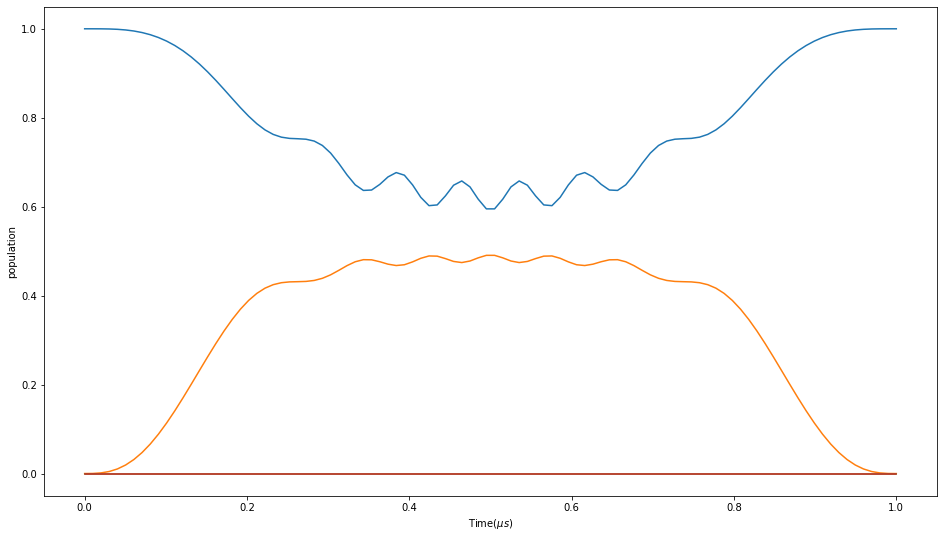

In [165]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times, a.expect[0])
ax.plot(times, a.expect[1])
ax.plot(times, b.expect[0])
ax.plot(times, b.expect[1])
ax.set_xlabel('Time' r'$(\mu s)$') 
ax.set_ylabel('population')
plt.show()

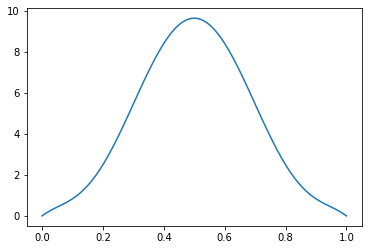

In [163]:
times = np.linspace(0.0, 1, 100)
test_omega = PulseShape(1)
plt.plot(times, test_omega(times, None))